# SIWIB 2

Autorzy: Adamski, Gilewski, Jedlikowski, Sienkiewicz

In [1]:
import os

from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, OPTICS

import stumpy

def topk(arr, k):
    values, counts = np.unique(arr, return_counts=True)
    return values[np.argsort(-counts)][:k]

sns.set_style('darkgrid') # nice plots
sns.set_context('talk') # big fonts
plt.rc('figure', figsize=(12, 8), dpi=150)
np.random.seed(42)

### 1. Choosing the protein

In [2]:
PROTEIN = "hnrnpc"
# PROTEIN = "hnrnpa2b1"

In [3]:
# DIRECTORIES TO LOAD THE DATA
FIBER_DATA_FOLDER = Path(f"./RBP-footprinting-data/{PROTEIN.upper()}")
EXPECTED_PATTERN_FILE = FIBER_DATA_FOLDER / f"{PROTEIN}_expected_pattern.txt"
PATTERN_CANDIDATES_FOLDER = FIBER_DATA_FOLDER / f"{PROTEIN}_binding_sites_fshape"
PATTERN_SEARCH_FOLDER = FIBER_DATA_FOLDER / f"{PROTEIN}_search_fshape"

### 2. Check the expected pattern and its length

In [4]:
# Load the expected fibre pattern
def read_pattern(path):
    return pd.read_csv(path, sep='\t', header=None, names=['fshape', 'letter'])

pattern_data = read_pattern(EXPECTED_PATTERN_FILE)
vanilla_window_size = len(pattern_data.fshape)
print(f"Expected pattern vanilla length: {vanilla_window_size}")
pattern_data

Expected pattern vanilla length: 6


,fshape,letter
0,0.00,N
1,1.25,T
2,1.15,T
3,3.00,T
4,1.70,T
5,0.10,N


### 3. Define lengths of promising patterns:

In [5]:
# default window size - based on the example pattern
n = len(pattern_data)
window_sizes = [n, n+1, n+2]

### 4. Extraction of all the promising patterns (without NaN and with at least one nucleotide with fSHAPE >1.0)

In [6]:
def is_promising(window):
    """
    Checks if a given window, proposes interesting pattern
    """
    if window.isnull().any():
        return False
    return (window > 1).any()

In [7]:
"""
Main Loop
1. For each data file:
    - Read it to dataframe
    - For each window check for each row is it's an anchor of an interesting gene window
    - If yes than get patterns for the desired window sizes based on that anchors 
    - Add those patterns to the apropriate list in the `patterns_by_length` dict:
        - no padding
        - left or right padding, 
        - left and right padding
"""

patterns_by_length = defaultdict(list)
fshapes_by_length = defaultdict(list)

for file in PATTERN_CANDIDATES_FOLDER.glob("*"):
    sequence = read_pattern(file)
    for window_size in window_sizes:
        interesting_patterns = sequence.fshape.rolling(window_size).apply(is_promising)
        for index, row in sequence.iterrows():
            if interesting_patterns[index] == 1:
                patterns_by_length[window_size].append(sequence.letter[index - window_size + 1 : index + 1].to_numpy())
                fshapes_by_length[window_size].append( sequence.fshape[index - window_size + 1 : index + 1].to_numpy())
                
for k, x in patterns_by_length.items(): 
    print(f'For length {k} found {len(x)} interesting patterns')
    
print('example pattern:')
length = 6
print(patterns_by_length[length][0])
print(fshapes_by_length[length][0])

For length 6 found 667 interesting patterns
For length 7 found 716 interesting patterns
For length 8 found 757 interesting patterns
example pattern:
['A' 'C' 'C' 'T' 'A' 'A']
[0.6515937  0.24909604 0.12207691 0.27174267 0.59119743 1.78560917]


### 5. Perform clustering for extracted patterns:

KMeans explained variance:  [0.85918968 0.04786084]
DBSCAN explained variance:  [0.85918968 0.04786084]
OPTICS explained variance:  [0.85918968 0.04786084]


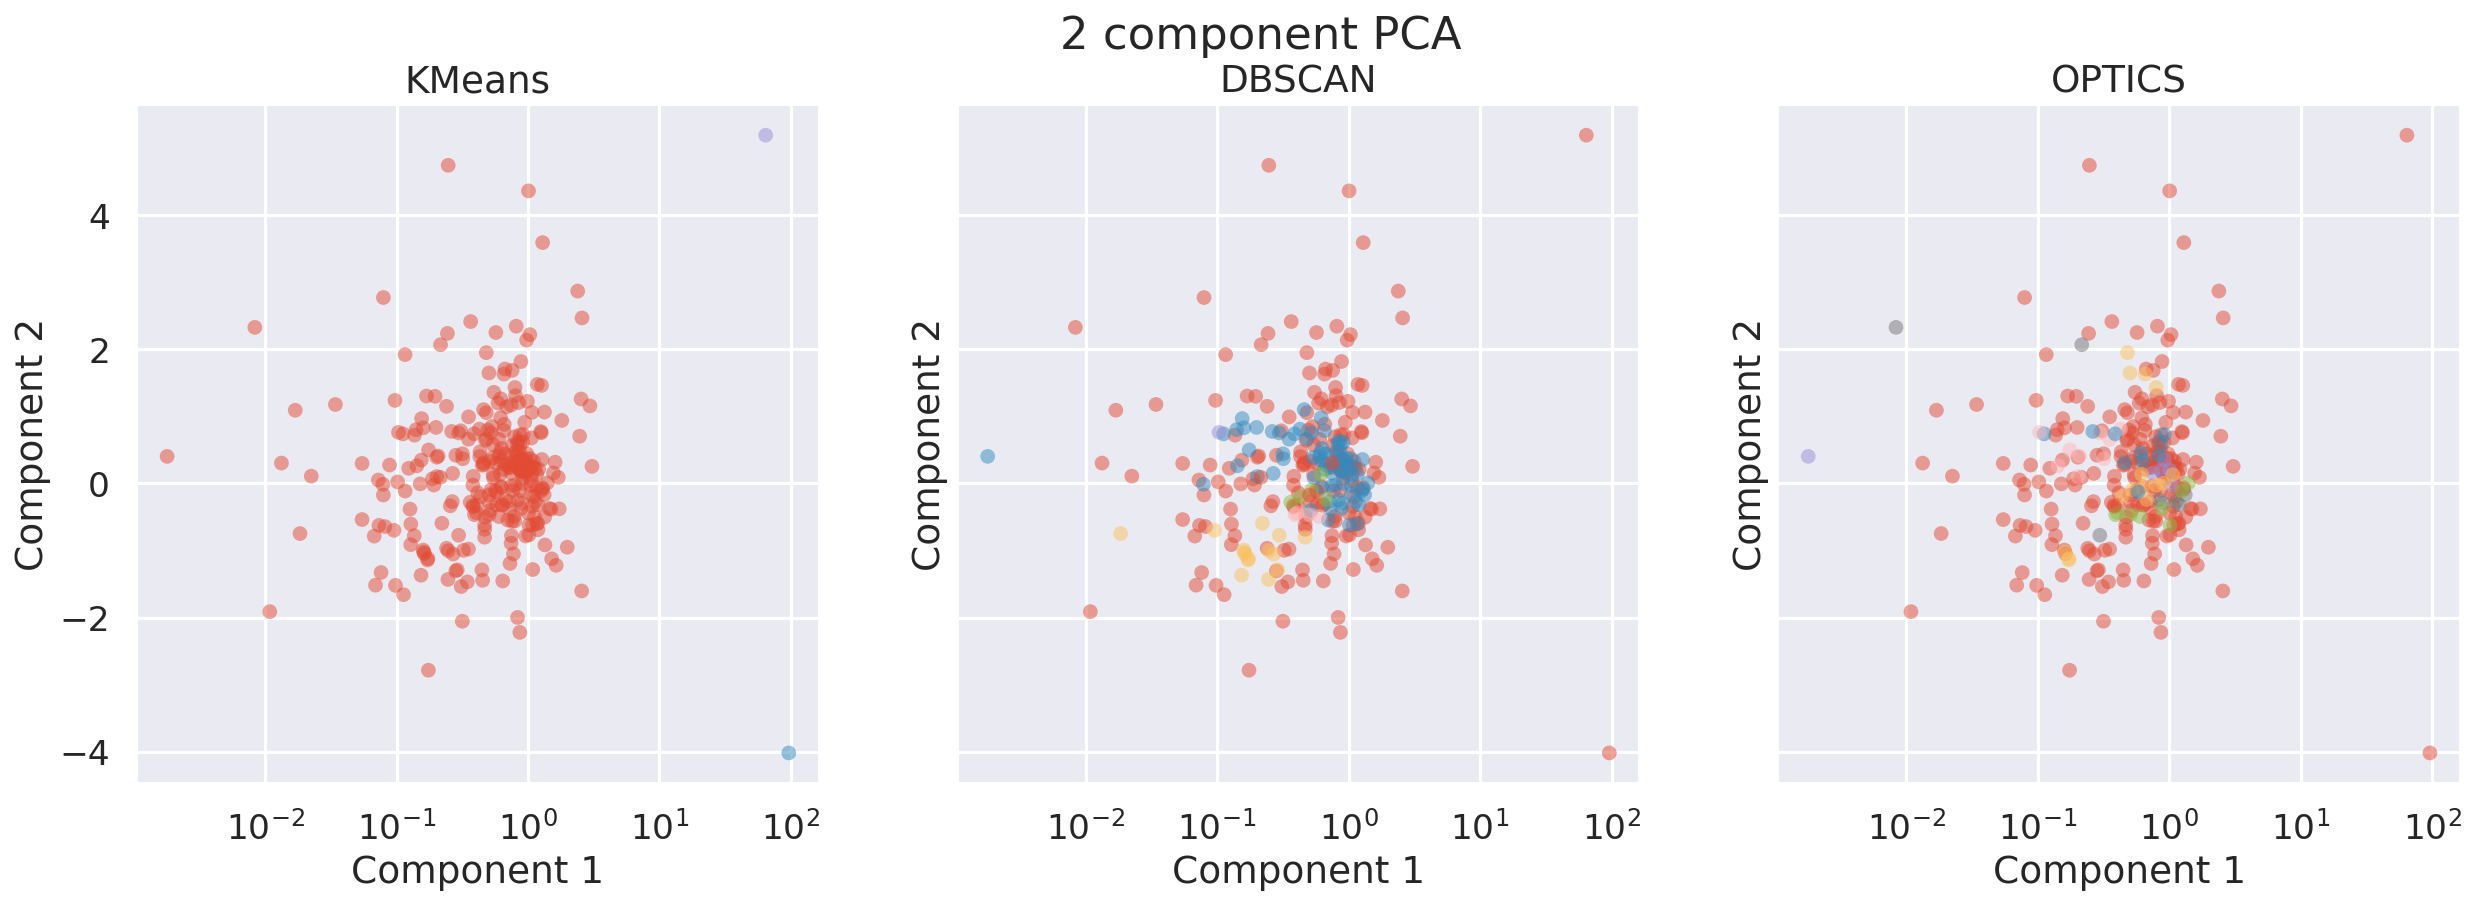

In [8]:
def plot_pca(X, labels, *, ax, label):
    targets = np.unique(labels)
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    for target in targets:
        mask = labels == target
        ax.scatter(components[:, 0][mask], components[:, 1][mask], s=50, alpha=0.5, edgecolors='none')
        
    ax.set_title(label)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_xscale('log')
    print(label, "explained variance: ", pca.explained_variance_ratio_)
    #plt.legend(targets, loc="center right") # useless
    

length = 6
fshapes = fshapes_by_length[length]
    
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 6), ncols=3, sharey=True)
plt.suptitle("2 component PCA")

y_pred = KMeans(n_clusters=3).fit_predict(fshapes)
plot_pca(fshapes, y_pred, ax=ax1, label='KMeans')

clustering = DBSCAN(eps=0.6, min_samples=3).fit(fshapes)
y_pred = clustering.labels_.astype(int)
plot_pca(fshapes, y_pred, ax=ax2, label='DBSCAN')

clustering = OPTICS(min_samples=3).fit(fshapes)
y_pred = clustering.labels_.astype(int)
plot_pca(fshapes, y_pred, ax=ax3, label='OPTICS')

plt.show()

### 6. Find consensus for top 3 clusters (for each pattern length)

Top clusters for length 6: [ 5 26 29]
Consensus motif in cluster 05: CATTTT
Consensus motif in cluster 26: TAAAAT
Consensus motif in cluster 29: ATTGTT
Top clusters for length 7: [ 8  3 15]
Consensus motif in cluster 08: AAACAGA
Consensus motif in cluster 03: CCGGTGT
Consensus motif in cluster 15: TCACCTC
Top clusters for length 8: [ 5  1 11]
Consensus motif in cluster 05: AAACAGAC
Consensus motif in cluster 01: AATGGTAA
Consensus motif in cluster 11: AGCTGAGC


Text(0.5, 0, 'Position in pattern')

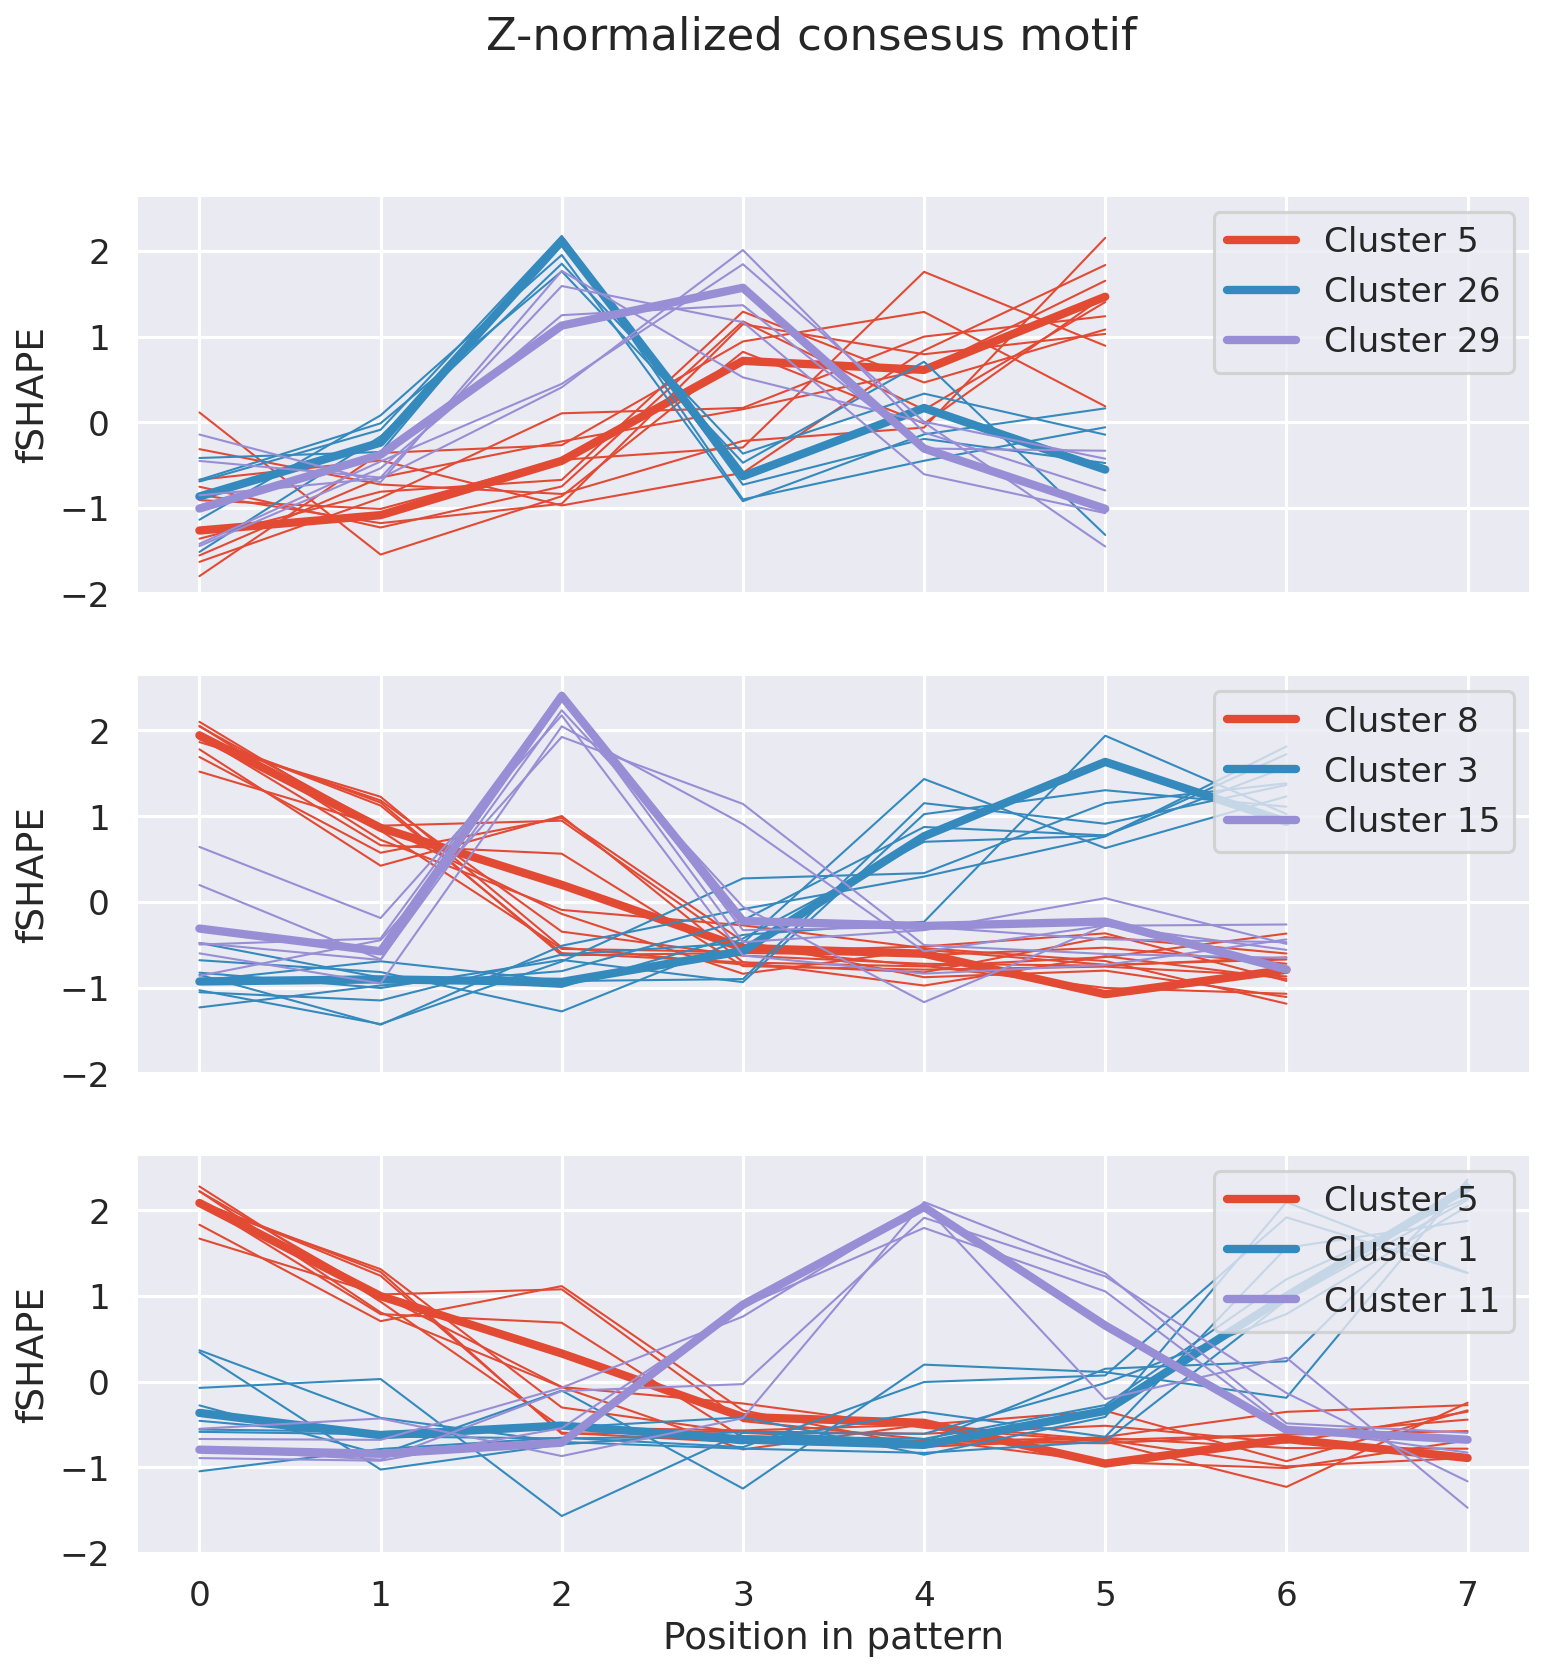

In [9]:
k_clusters = 3
consensus_patterns = ['NTTTTN']
consensus_fshapes = [pattern_data.fshape.to_numpy()]

fig, axs = plt.subplots(figsize=(12, 12), nrows=3, sharex=True, sharey=True)
colors = sns.color_palette(n_colors=k_clusters)

for length, ax in zip(window_sizes, axs):
    patterns = np.array(patterns_by_length[length])
    fshapes = np.array(fshapes_by_length[length])
    clustering = OPTICS(min_samples=3).fit(fshapes)
    labels = clustering.labels_.astype(int)
    top_labels = topk(labels[labels != -1], k=k_clusters)
    print(f'Top clusters for length {length}: {top_labels}')
    
    for label, color in zip(top_labels, colors):
        cluster_fshapes = fshapes[labels == label]
        cluster_patterns = patterns[labels == label]
        
        _, index, _ = stumpy.ostinato(cluster_fshapes, length)
        consensus_motif = cluster_fshapes[index]
        consensus_patterns.append(''.join(cluster_patterns[index]))
        consensus_fshapes.append(cluster_fshapes[index])
        print(f'Consensus motif in cluster {label:02d}: {"".join(cluster_patterns[index])}')

        for i, motif in enumerate(cluster_fshapes):
            lw = 4 if i == index else 1
            name = f'Cluster {label}' if i == index else None
            ax.plot(stumpy.core.z_norm(motif), color=color, lw=lw, label=name)

    ax.legend(loc='upper right')
    ax.set_ylabel('fSHAPE')
        
plt.suptitle('Z-normalized consesus motif')
plt.xlabel('Position in pattern')

## Comparison of nucleotide sequences

In [10]:
def ssf(xs, ys):
    # sequence similarity function
    assert len(xs) == len(ys)
    assert len(xs) > 0
    total = 0
    for x, y in zip(xs, ys):
        if x == y or x == 'N' or y == 'N':
            # nucleotides are equal or allowed to have any value (N)
            total += 2
        elif (x == 'A' and y == 'G') or (x == 'G' and y == 'A') or \
                (x == 'C' and y == 'U') or (x == 'U' and y == 'C') or \
                (x == 'C' and y == 'T') or (x == 'T' and y == 'C'):
            # nucleotides in the same group
            total += 1
        # otherwise no points
    return total / len(xs)

ssf('NTTTTN', 'TGATTT')

1.3333333333333333

In [11]:
from tqdm import tqdm

results = defaultdict(list)
for path in PATTERN_SEARCH_FOLDER.glob('*'):
    filename = os.path.basename(path)
    transcript = pd.read_csv(path, sep='\t', header=None, names=['fshape', 'letter', 'shape']).drop(columns=['shape'])
    for fshape, pattern in zip(consensus_fshapes, consensus_patterns):
        length = len(pattern)
        found = 0
        for i in range(0, len(transcript) - length):
            df = transcript.iloc[i:i+length, :]
            if not is_promising(df.fshape): continue
            zned = stumpy.core.mass(fshape, df.fshape)[0]
            if zned > 2.5: continue
            seq = ''.join(df.letter)
            if length == 6: 
                sim = ssf(seq, 'NTTTTN')
            elif length == 7:
                sim = max(ssf(seq, 'NNTTTTN'), ssf(seq, 'NTTTTNN'))
            elif length == 8:
                sim = ssf(seq, 'NNTTTTNN')
            else:
                assert False
            results[pattern].append(dict(sequence=seq, file=filename, start=i+1, end=i+length, znED=zned, ssf=sim, aS=10*zned - sim))
            found += 1
        print(f'found {found} matches for pattern {pattern} in {filename}')

for k, x in results.items():
    df = pd.DataFrame(x).sort_values(by='aS')
    results[k] = df

found 113 matches for pattern NTTTTN in hnrnpc_NM_000067_CA2.txt
found 167 matches for pattern CATTTT in hnrnpc_NM_000067_CA2.txt
found 99 matches for pattern TAAAAT in hnrnpc_NM_000067_CA2.txt
found 122 matches for pattern ATTGTT in hnrnpc_NM_000067_CA2.txt
found 165 matches for pattern AAACAGA in hnrnpc_NM_000067_CA2.txt
found 145 matches for pattern CCGGTGT in hnrnpc_NM_000067_CA2.txt
found 79 matches for pattern TCACCTC in hnrnpc_NM_000067_CA2.txt
found 142 matches for pattern AAACAGAC in hnrnpc_NM_000067_CA2.txt
found 99 matches for pattern AATGGTAA in hnrnpc_NM_000067_CA2.txt
found 76 matches for pattern AGCTGAGC in hnrnpc_NM_000067_CA2.txt
found 56 matches for pattern NTTTTN in hnrnpc_NM_000422_KRT17.txt
found 78 matches for pattern CATTTT in hnrnpc_NM_000422_KRT17.txt
found 40 matches for pattern TAAAAT in hnrnpc_NM_000422_KRT17.txt
found 64 matches for pattern ATTGTT in hnrnpc_NM_000422_KRT17.txt
found 63 matches for pattern AAACAGA in hnrnpc_NM_000422_KRT17.txt
found 60 match

found 132 matches for pattern NTTTTN in hnrnpc_NM_001631_ALPI.txt
found 175 matches for pattern CATTTT in hnrnpc_NM_001631_ALPI.txt
found 110 matches for pattern TAAAAT in hnrnpc_NM_001631_ALPI.txt
found 147 matches for pattern ATTGTT in hnrnpc_NM_001631_ALPI.txt
found 145 matches for pattern AAACAGA in hnrnpc_NM_001631_ALPI.txt
found 148 matches for pattern CCGGTGT in hnrnpc_NM_001631_ALPI.txt
found 90 matches for pattern TCACCTC in hnrnpc_NM_001631_ALPI.txt
found 130 matches for pattern AAACAGAC in hnrnpc_NM_001631_ALPI.txt
found 119 matches for pattern AATGGTAA in hnrnpc_NM_001631_ALPI.txt
found 92 matches for pattern AGCTGAGC in hnrnpc_NM_001631_ALPI.txt
found 142 matches for pattern NTTTTN in hnrnpc_NM_001632_ALPP.txt
found 190 matches for pattern CATTTT in hnrnpc_NM_001632_ALPP.txt
found 135 matches for pattern TAAAAT in hnrnpc_NM_001632_ALPP.txt
found 160 matches for pattern ATTGTT in hnrnpc_NM_001632_ALPP.txt
found 165 matches for pattern AAACAGA in hnrnpc_NM_001632_ALPP.txt
fo

found 55 matches for pattern AAACAGA in hnrnpc_NM_004207_SLC16A3.txt
found 47 matches for pattern CCGGTGT in hnrnpc_NM_004207_SLC16A3.txt
found 26 matches for pattern TCACCTC in hnrnpc_NM_004207_SLC16A3.txt
found 47 matches for pattern AAACAGAC in hnrnpc_NM_004207_SLC16A3.txt
found 37 matches for pattern AATGGTAA in hnrnpc_NM_004207_SLC16A3.txt
found 33 matches for pattern AGCTGAGC in hnrnpc_NM_004207_SLC16A3.txt
found 36 matches for pattern NTTTTN in hnrnpc_NM_004428_EFNA1.txt
found 48 matches for pattern CATTTT in hnrnpc_NM_004428_EFNA1.txt
found 33 matches for pattern TAAAAT in hnrnpc_NM_004428_EFNA1.txt
found 39 matches for pattern ATTGTT in hnrnpc_NM_004428_EFNA1.txt
found 33 matches for pattern AAACAGA in hnrnpc_NM_004428_EFNA1.txt
found 36 matches for pattern CCGGTGT in hnrnpc_NM_004428_EFNA1.txt
found 25 matches for pattern TCACCTC in hnrnpc_NM_004428_EFNA1.txt
found 24 matches for pattern AAACAGAC in hnrnpc_NM_004428_EFNA1.txt
found 19 matches for pattern AATGGTAA in hnrnpc_NM

found 27 matches for pattern TCACCTC in hnrnpc_NM_017527_LY6K.txt
found 39 matches for pattern AAACAGAC in hnrnpc_NM_017527_LY6K.txt
found 33 matches for pattern AATGGTAA in hnrnpc_NM_017527_LY6K.txt
found 24 matches for pattern AGCTGAGC in hnrnpc_NM_017527_LY6K.txt
found 17 matches for pattern NTTTTN in hnrnpc_NM_020130_C8orf4.txt
found 22 matches for pattern CATTTT in hnrnpc_NM_020130_C8orf4.txt
found 19 matches for pattern TAAAAT in hnrnpc_NM_020130_C8orf4.txt
found 15 matches for pattern ATTGTT in hnrnpc_NM_020130_C8orf4.txt
found 18 matches for pattern AAACAGA in hnrnpc_NM_020130_C8orf4.txt
found 18 matches for pattern CCGGTGT in hnrnpc_NM_020130_C8orf4.txt
found 14 matches for pattern TCACCTC in hnrnpc_NM_020130_C8orf4.txt
found 14 matches for pattern AAACAGAC in hnrnpc_NM_020130_C8orf4.txt
found 12 matches for pattern AATGGTAA in hnrnpc_NM_020130_C8orf4.txt
found 11 matches for pattern AGCTGAGC in hnrnpc_NM_020130_C8orf4.txt
found 14 matches for pattern NTTTTN in hnrnpc_NM_03352

In [18]:
xls = pd.ExcelWriter('combo.xlsx', engine='xlsxwriter') 
for k, x in results.items():
    x.to_csv(f'out/{k}.csv', index=False)
    x.to_excel(xls, sheet_name=k, index=False, startrow=0, startcol=0)
xls.save()

In [13]:
!ls out

AAACAGA.csv   AATGGTAA.csv  ATTGTT.csv	CCGGTGT.csv  TAAAAT.csv
AAACAGAC.csv  AGCTGAGC.csv  CATTTT.csv	NTTTTN.csv   TCACCTC.csv


In [14]:
sample = pd.read_csv('out/CATTTT.csv')
sample

,sequence,file,start,end,znED,ssf,aS
0,GGACTT,hnrnpc_NM_001632_ALPP.txt,2267,2272,0.160353,1.166667,0.436864
1,GTTTCG,hnrnpc_NM_005627_SGK1.txt,1658,1663,0.294922,1.833333,1.115889
2,TTCTTT,hnrnpc_NM_001136025_PLS3.txt,2560,2565,0.333325,1.833333,1.499920
3,GGCTTA,hnrnpc_NM_001631_ALPI.txt,1114,1119,0.332987,1.500000,1.829873
4,CCTGGT,hnrnpc_NM_001195129_PRSS56.txt,535,540,0.431210,1.166667,3.145438
...,...,...,...,...,...,...,...
3446,AAGAAC,hnrnpc_NM_014220_TM4SF1.txt,844,849,2.484707,0.666667,24.180401
3447,GGAGGA,hnrnpc_NM_001136025_PLS3.txt,917,922,2.489686,0.666667,24.230194
3448,GAAGGG,hnrnpc_NM_001195129_PRSS56.txt,1841,1846,2.490126,0.666667,24.234589
3449,AAGGAC,hnrnpc_NM_001553_IGFBP7.txt,646,651,2.490973,0.666667,24.243060


In [15]:
sample[sample.znED < 1.5].sort_values(by='ssf', ascending=False)

,sequence,file,start,end,znED,ssf,aS
67,TTTTTA,hnrnpc_NM_001199622_NCOA7.txt,1917,1922,0.852467,2.000000,6.524668
294,ATTTTA,hnrnpc_NM_001875_CPS1.txt,2785,2790,1.273084,2.000000,10.730839
272,ATTTTA,hnrnpc_NM_004181_UCHL1.txt,578,583,1.245794,2.000000,10.457939
118,GTTTTT,hnrnpc_NM_001875_CPS1.txt,349,354,1.012303,2.000000,8.123031
210,ACTTTA,hnrnpc_NM_001769_CD9.txt,1239,1244,1.139900,1.833333,9.565670
...,...,...,...,...,...,...,...
253,CAAGAC,hnrnpc_NM_001631_ALPI.txt,83,88,1.080162,0.666667,10.134953
459,GGAGGG,hnrnpc_NM_005860_FSTL3.txt,1493,1498,1.285064,0.666667,12.183977
546,AGAGAA,hnrnpc_NM_001875_CPS1.txt,3248,3253,1.349072,0.666667,12.824054
242,CAGGGT,hnrnpc_NM_004826_ECEL1.txt,2739,2744,1.062440,0.666667,9.957731
